In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as pltt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [2]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DXC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXC.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DYC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYC.data', dtype='>f4')
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4')
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')

In [3]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [4]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [5]:
zphi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm,num_eigen=11,init_vector=None,num_Lanczos=None,iteration=None,tolerance=0)

In [6]:
#trajectories
ds = xr.open_zarr('/swot/SUM03/spencer/rechunked_21456.zarr')
ds = ds.isel(niter=slice(1,74))
ds['time'] = ds['niter']*3600/144
ds = ds.assign_coords({"time": ds.time})
ds = ds.swap_dims({"niter": "time"})
ds = ds.where((ds.u!=-999).all(dim='time'))

In [104]:
# Load velocities
vels_filtered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/filtered_vels.zarr')
vels_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/unfiltered_vels.zarr')
eta_filtered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/filtered_eta_nom.zarr')
eta_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_1_gins/unfiltered_eta_nom.zarr')

uvel_eul = xr.open_zarr('/swot/SUM03/spencer/PV_fields/uvel_centered.zarr')
vvel_eul = xr.open_zarr('/swot/SUM03/spencer/PV_fields/vvel_centered.zarr')
eta_eul = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/baro_nom.zarr')

uvel_filtered = vels_filtered.u.isel(time=slice(2,110))
vvel_filtered = vels_filtered.v.isel(time=slice(2,110))
ssh_filtered = eta_filtered.eta.isel(time=slice(2,110))


grid = Grid(uvel_eul, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [105]:
f = 2*2*np.pi/24/3600*np.sin(YC.reshape(2160,2160)*np.pi/180)

In [106]:
def lanczos(x, a):
    return np.sinc(x/a)
def sinc2(x, a):
    return np.sinc(x/a)

window_width=72
weight = xr.DataArray(sinc2(np.expand_dims(np.arange(-window_width/2,window_width/2),1),np.expand_dims(np.pi/f[:,0]/3600*1.1,0)), dims=['window','j'])
#weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
nofiles=300
u_eul_filtered = uvel_eul.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
v_eul_filtered = vvel_eul.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
dens_eul_filtered = Density.isel(k=slice(0,3)).chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
u_eul_filtered = u_eul_filtered.isel(time=slice(0,nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.isel(time=slice(0,nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
dens_eul_filtered = dens_eul_filtered.isel(time=slice(0,nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
u_eul_filtered = u_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
u_eul_filtered = u_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
v_eul_filtered = v_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
v_eul_filtered = v_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
dens_eul_filtered = dens_eul_filtered.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
dens_eul_filtered = dens_eul_filtered.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})

In [107]:
#Add back in temp and salinity
temp_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/theta_mean.zarr')
salt_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt_mean.zarr')

In [108]:
temp_mean_rename = temp_mean.theta.isel(k=slice(0,4)).rename({'i':'x0','j':'y0','k':'z0'})
temp_mean_rename = temp_mean_rename.assign_coords({'z0':ds.t.z0[-1::-1]})
temp_mean_rename = temp_mean_rename.reindex(z0=temp_mean_rename.z0[-1::-1])

salt_mean_rename = salt_mean.salt.isel(k=slice(0,4)).rename({'i':'x0','j':'y0','k':'z0'})
salt_mean_rename = salt_mean_rename.assign_coords({'z0':ds.s.z0[-1::-1]})
salt_mean_rename = salt_mean_rename.reindex(z0=salt_mean_rename.z0[-1::-1])

In [109]:
weight = xr.DataArray(sinc2(np.expand_dims(np.arange(-window_width/2,window_width/2),1),np.expand_dims(np.pi/f[:,0]/3600,0)), dims=['window','y0'])
windowed_u = (ds.u.rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')).sel(time=0).rename({'z0':'k'})
windowed_v = (ds.v.rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')).sel(time=0).rename({'z0':'k'})
windowed_s = ((ds.s+salt_mean_rename).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')).sel(time=0)
windowed_t = ((ds.t+temp_mean_rename).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')).sel(time=0)
windowed_dens = jmd95numba.rho(windowed_s, windowed_t, 0).rename({'z0':'k'})


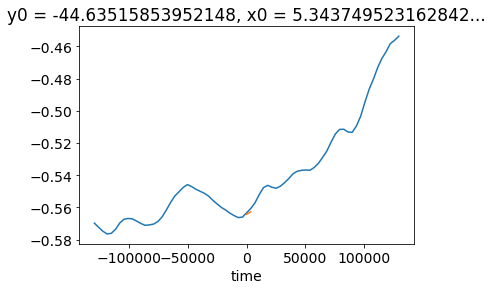

In [11]:
ds.t.isel(x0=1000,y0=1000,z0=1).plot()

(ds.t.rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
).isel(x0=1000,y0=1000,z0=1).plot()

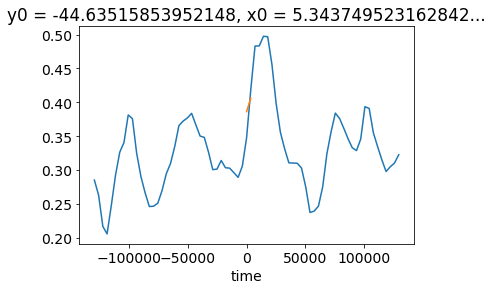

In [12]:
ds.v.isel(x0=1000,y0=1000,z0=3).plot()

(ds.v.rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
).isel(x0=1000,y0=1000,z0=3).plot()

In [13]:
f_array = (xr.DataArray(-f[:,0]*3600/np.pi,dims=['y0']).assign_coords(y0=ds.y0))

In [14]:
from scipy import signal
def try_filtering(u_demeaned,f_array):
    sos = signal.butter(10, f_array, 'lp', fs=1, output='sos')
    filtered_u = signal.sosfilt(sos, u_demeaned)
    return filtered_u

In [15]:
import warnings; warnings.simplefilter('ignore')
for y in range(0,2160):
    if np.mod(y,10)==0:
        print(y)
    u_demeaned1 = (ds.u-ds.u.mean('time')).transpose('x0','y0','z0','time').isel(y0=y)
    u_bfiltered1 = xr.apply_ufunc(try_filtering,u_demeaned1,f_array.isel(y0=y), 
                                 input_core_dims=[['time'],[]],output_core_dims=[['time']],dask='allowed')

    v_demeaned1 = (ds.v-ds.v.mean('time')).transpose('x0','y0','z0','time').isel(y0=y)
    v_bfiltered1 = xr.apply_ufunc(try_filtering,v_demeaned1,f_array.isel(y0=y), 
                                 input_core_dims=[['time'],[]],output_core_dims=[['time']],dask='allowed')
    if (y==0):
        u_bfiltered = u_bfiltered1
        v_bfiltered = v_bfiltered1
        u_demeaned = u_demeaned1
        v_demeaned = v_demeaned1
    else:
        u_bfiltered = xr.concat([u_bfiltered,u_bfiltered1],dim='time')
        v_bfiltered = xr.concat([v_bfiltered,v_bfiltered1],dim='time')
        u_demeaned = xr.concat([u_demeaned,u_demeaned1],dim='time')
        v_demeaned = xr.concat([v_demeaned,v_demeaned1],dim='time')
        

0
10
20
30
40


KeyboardInterrupt: 

In [ ]:
with ProgressBar():
    ps_bunfilt = xrft.power_spectrum(u_demeaned,dim=['time']).compute()
    ps_bfilt = xrft.power_spectrum(u_bfiltered,dim=['time']).compute()

In [ ]:
ps_bunfilt.mean(['x0','y0']).isel(z0=0).plot()
plt.xscale('log')
plt.yscale('log')
plt.ylim(1,1000)

ps_bfilt.mean(['x0','y0']).isel(z0=0).plot()
plt.xscale('log')
plt.yscale('log')
plt.ylim(1,1000)

In [164]:
from scipy import signal
sos = signal.butter(10, 0.1, 'lp', fs=1, output='sos')

filtered = signal.sosfilt(sos, ds.u.isel(x0=1000,y0=1000,z0=3)-ds.u.isel(x0=1000,y0=1000,z0=3).mean())

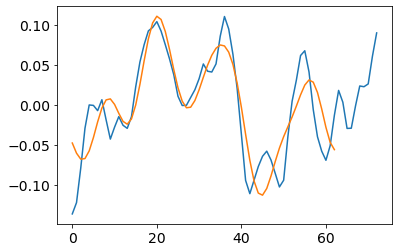

In [165]:
plt.plot((ds.u.isel(x0=1000,y0=1000,z0=3)-ds.u.isel(x0=1000,y0=1000,z0=3).mean()))
plt.plot(filtered[10:])


In [110]:
uvel_eul = uvel_eul.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
uvel_eul = uvel_eul.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
vvel_eul = vvel_eul.assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
vvel_eul = vvel_eul.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})
Density_top3 = Density.isel(k=slice(0,3)).assign_coords(x0=("i", uvel_filtered.x0.values)).swap_dims({"i": "x0"})
Density_top3 = Density_top3.assign_coords(y0=("j", uvel_filtered.y0.values)).swap_dims({"j": "y0"})

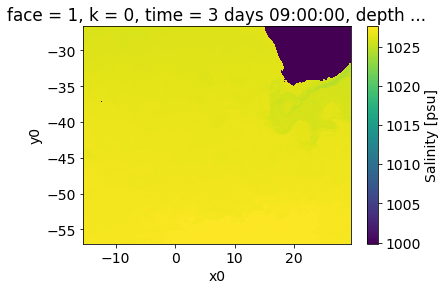

In [111]:
Density_top3.isel(time=10).isel(k=0).plot()

In [112]:
lons, lats = np.meshgrid(uvel_filtered.x0.values, uvel_filtered.y0.values)

In [113]:
def target_area_def(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat = center_point.x0.values.item(), -center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 1, 0))

def ufunc_resample(data):
    target_def = target_area_def(data.isel(k=0),'U')
    source_def = geometry.SwathDefinition(lons=lons, lats=-lats)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['x0','y0'],['x0','y0']],output_core_dims=[['y1','x1']])
    return resampled

In [114]:
u_eul_resampled = ufunc_resample(uvel_eul.U.isel(time=150).load())
v_eul_resampled = ufunc_resample(vvel_eul.V.isel(time=150).load())
dens_eul_resampled = ufunc_resample(Density_top3.isel(time=150).load())

u_eulf_resampled = ufunc_resample(u_eul_filtered.isel(time=150).load())
v_eulf_resampled = ufunc_resample(v_eul_filtered.isel(time=150).load())
dens_eulf_resampled = ufunc_resample(dens_eul_filtered.isel(time=150).load())


u_resampled = ufunc_resample(windowed_u.load())
v_resampled = ufunc_resample(windowed_v.load())
dens_resampled = ufunc_resample(windowed_dens.load())
y_resampled = ufunc_resample((uvel_eul.y0*xr.ones_like(uvel_eul.U.isel(k=slice(0,3),time=150))).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [115]:
def ufunc_resample(data):
    target_def = target_area_def(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lons, lats=-lats)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['x0','y0'],['x0','y0']],output_core_dims=[['y1','x1']])
    return resampled
u_eul_resampled0 = ufunc_resample(uvel_eul.U.isel(k=0).load())
v_eul_resampled0 = ufunc_resample(vvel_eul.V.isel(k=0).load())
dens_resampled0 = ufunc_resample(Density_top3.isel(k=0).load())
u_eul_resampled1 = ufunc_resample(uvel_eul.U.isel(k=1).load())
v_eul_resampled1 = ufunc_resample(vvel_eul.V.isel(k=1).load())
dens_resampled1 = ufunc_resample(Density_top3.isel(k=1).load())
u_eul_resampled2 = ufunc_resample(uvel_eul.U.isel(k=2).load())
v_eul_resampled2 = ufunc_resample(vvel_eul.V.isel(k=2).load())
dens_resampled2 = ufunc_resample(Density_top3.isel(k=2).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [116]:
with ProgressBar():
    u2_xs_unfilt0 = xrft.dft(u_eul_resampled0.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()#,window=True,window_correction=True
    v2_xs_unfilt0 = xrft.dft(v_eul_resampled0.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()
    dens_xs_unfilt0 = xrft.dft(dens_resampled0.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()
    u2_xs_unfilt1 = xrft.dft(u_eul_resampled1.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()
    v2_xs_unfilt1 = xrft.dft(v_eul_resampled1.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()
    dens_xs_unfilt1 = xrft.dft(dens_resampled1.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()
    u2_xs_unfilt2 = xrft.dft(u_eul_resampled2.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()
    v2_xs_unfilt2 = xrft.dft(v_eul_resampled2.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()
    dens_xs_unfilt2 = xrft.dft(dens_resampled2.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:336: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [117]:
kx = v2_xs_unfilt0.freq_x1
ky = v2_xs_unfilt0.freq_y1
kr = np.sqrt(kx**2+ky**2)
omegaM = np.nan*np.ones([kr.shape[0], kr.shape[1], 11])
for i in range(1,11):
    Kdi = 1/RdS[i]
    omegaM[:,:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600
u2_xs_tofilt0 = u2_xs_unfilt0.where(np.abs(u2_xs_unfilt0.freq_time)*xr.ones_like(u2_xs_unfilt0)<omegaM[:,:,10]/np.pi/2)
v2_xs_tofilt0 = v2_xs_unfilt0.where(np.abs(v2_xs_unfilt0.freq_time)*xr.ones_like(v2_xs_unfilt0)<omegaM[:,:,10]/np.pi/2)
dens_xs_tofilt0 = dens_xs_unfilt0.where(np.abs(dens_xs_unfilt0.freq_time)*xr.ones_like(dens_xs_unfilt0)<omegaM[:,:,10]/np.pi/2)
u2_xs_tofilt1 = u2_xs_unfilt1.where(np.abs(u2_xs_unfilt0.freq_time)*xr.ones_like(u2_xs_unfilt0)<omegaM[:,:,10]/np.pi/2)
v2_xs_tofilt1 = v2_xs_unfilt1.where(np.abs(v2_xs_unfilt0.freq_time)*xr.ones_like(v2_xs_unfilt0)<omegaM[:,:,10]/np.pi/2)
dens_xs_tofilt1 = dens_xs_unfilt1.where(np.abs(dens_xs_unfilt0.freq_time)*xr.ones_like(dens_xs_unfilt0)<omegaM[:,:,10]/np.pi/2)
u2_xs_tofilt2 = u2_xs_unfilt2.where(np.abs(u2_xs_unfilt0.freq_time)*xr.ones_like(u2_xs_unfilt0)<omegaM[:,:,10]/np.pi/2)
v2_xs_tofilt2 = v2_xs_unfilt2.where(np.abs(v2_xs_unfilt0.freq_time)*xr.ones_like(v2_xs_unfilt0)<omegaM[:,:,10]/np.pi/2)
dens_xs_tofilt2 = dens_xs_unfilt2.where(np.abs(dens_xs_unfilt0.freq_time)*xr.ones_like(dens_xs_unfilt0)<omegaM[:,:,10]/np.pi/2)

In [118]:
u2_inv0 = xrft.idft(u2_xs_tofilt0.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
u2_inv1 = xrft.idft(u2_xs_tofilt1.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
u2_inv2 = xrft.idft(u2_xs_tofilt2.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
v2_inv0 = xrft.idft(v2_xs_tofilt0.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
v2_inv1 = xrft.idft(v2_xs_tofilt1.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
v2_inv2 = xrft.idft(v2_xs_tofilt2.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
dens_inv0 = xrft.idft(dens_xs_tofilt0.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
dens_inv1 = xrft.idft(dens_xs_tofilt1.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()
dens_inv2 = xrft.idft(dens_xs_tofilt2.fillna(0), dim=['freq_x1','freq_y1','freq_time']).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:506: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.idft to preserve the theoretical phasing and amplitude of Inverse Fourier Transform. Consider using xrft.ifft to ensure future compatibility with numpy.ifft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


In [119]:
grid1 = Grid(u_eul_resampled, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})

In [120]:
da_DXC = xr.DataArray(data = DXC.reshape(2160,2160),dims=['j','i_g'])
da_DYC = xr.DataArray(data = DYC.reshape(2160,2160),dims=['j_g','i'])

In [121]:
dx = 270000/256
dy = 270000/256

In [122]:
omega_x = -(v_eul_resampled.sel(k=0)-v_eul_resampled.sel(k=2))/(DRC[2]+DRC[1])
omega_y = -(u_eul_resampled.sel(k=0)-u_eul_resampled.sel(k=2))/(DRC[2]+DRC[1])
zeta = (grid1.interp(grid1.diff(v_eul_resampled,'X')/dx,'X')-grid1.interp(grid1.diff(u_eul_resampled,'Y')/dy,'Y')).isel(k=1)
dsigdx = grid1.interp(grid1.diff((dens_eul_resampled-1000),'X')/dx,'X').isel(k=1)
dsigdy = grid1.interp(grid1.diff((dens_eul_resampled-1000),'Y')/dy,'Y').isel(k=1)
dsigdz = (dens_eul_resampled.sel(k=0)-dens_eul_resampled.sel(k=2))/(DRC[2]+DRC[1])
f = 2*2*np.pi/24/3600*np.sin(y_resampled*np.pi/180).isel(k=1)

In [123]:
omega_x_eulf = -(v_eulf_resampled.sel(k=0)-v_eulf_resampled.sel(k=2))/(DRC[2]+DRC[1])
omega_y_eulf = -(u_eulf_resampled.sel(k=0)-u_eulf_resampled.sel(k=2))/(DRC[2]+DRC[1])
zeta_eulf = (grid1.interp(grid1.diff(v_eulf_resampled,'X')/dx,'X')-grid1.interp(grid1.diff(u_eulf_resampled,'Y')/dy,'Y')).isel(k=1)
dsigdx_eulf = grid1.interp(grid1.diff((dens_eulf_resampled-1000),'X')/dx,'X').isel(k=1)
dsigdy_eulf = grid1.interp(grid1.diff((dens_eulf_resampled-1000),'Y')/dy,'Y').isel(k=1)
dsigdz_eulf = (dens_eulf_resampled.sel(k=0)-dens_eulf_resampled.sel(k=2))/(DRC[2]+DRC[1])
f = 2*2*np.pi/24/3600*np.sin(y_resampled*np.pi/180).isel(k=1)

In [124]:
#now with torres filter
omega_x_tor = -(v2_inv0-v2_inv2).isel(time=150)/(DRC[2]+DRC[1])
omega_y_tor = -(u2_inv0-u2_inv2).isel(time=150)/(DRC[2]+DRC[1])
zeta_tor = (grid1.interp(grid1.diff(v2_inv1,'X')/dx,'X')-grid1.interp(grid1.diff(u2_inv1,'Y')/dy,'Y')).isel(time=150)
dsigdx_tor = grid1.interp(grid1.diff((dens_inv1-1000),'X')/dx,'X').isel(time=150)
dsigdy_tor = grid1.interp(grid1.diff((dens_inv1-1000),'Y')/dy,'Y').isel(time=150)
dsigdz_tor = (dens_inv0-dens_inv2).isel(time=150)/(DRC[2]+DRC[1])
f = 2*2*np.pi/24/3600*np.sin(y_resampled*np.pi/180).isel(k=1)

In [125]:
#lag
omega_x_lag = -(v_resampled.isel(k=3)-v_resampled.isel(k=1))/(DRC[2]+DRC[1])
omega_y_lag = -(u_resampled.isel(k=3)-u_resampled.isel(k=1))/(DRC[2]+DRC[1])
zeta_lag = (grid1.interp(grid1.diff(v_resampled.isel(k=2),'X')/dx,'X')-grid1.interp(grid1.diff(u_resampled.isel(k=2),'Y')/dy,'Y'))
dsigdx_lag = grid1.interp(grid1.diff((dens_resampled.isel(k=2)-1000),'X')/dx,'X')
dsigdy_lag = grid1.interp(grid1.diff((dens_resampled.isel(k=2)-1000),'Y')/dy,'Y')
dsigdz_lag = (dens_resampled.isel(k=3)-dens_resampled.isel(k=1))/(DRC[2]+DRC[1])
f = 2*2*np.pi/24/3600*np.sin(y_resampled*np.pi/180).isel(k=1)

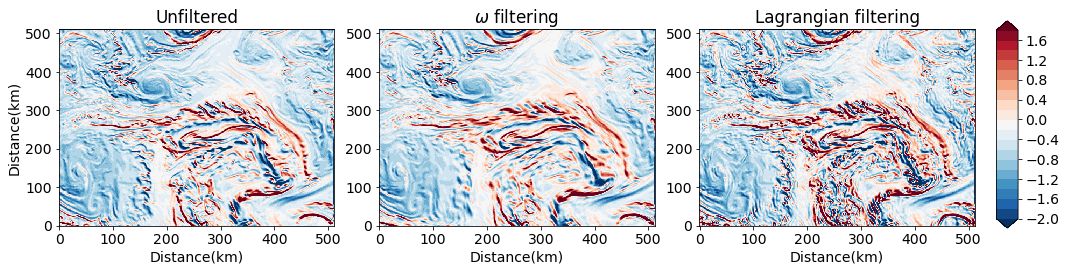

In [154]:
plt.figure(figsize=(15,4))

plt.subplot(131)
((omega_x*dsigdx+omega_y*dsigdy+(f+zeta)*dsigdz)*10**7).plot(levels=np.arange(-1,1,0.1)*2,add_colorbar=False)
plt.title('Unfiltered')
plt.xlabel('Distance(km)')
plt.ylabel('Distance(km)')

plt.subplot(132)
((omega_x_eulf*dsigdx_eulf+omega_y_eulf*dsigdy_eulf+(f+zeta_eulf)*dsigdz_eulf
).real*10**7).plot(levels=np.arange(-1,1,0.1)*2,add_colorbar=False)
plt.title('$\omega$ filtering')
plt.xlabel('Distance(km)')
plt.ylabel('')

plt.subplot(133)
cs = ((omega_x_lag*dsigdx_lag+omega_y_lag*dsigdy_lag+(f+zeta_lag)*dsigdz_lag
).real*10**7).plot(levels=np.arange(-1,1,0.1)*2,add_colorbar=False)#levels=np.arange(-1,1,0.1)*2*10**-7
plt.title('Lagrangian filtering')
plt.xlabel('Distance(km)')
plt.ylabel('')

plt.tight_layout()

fig=plt.gcf()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)

fig.savefig('potential_vorticity.png')

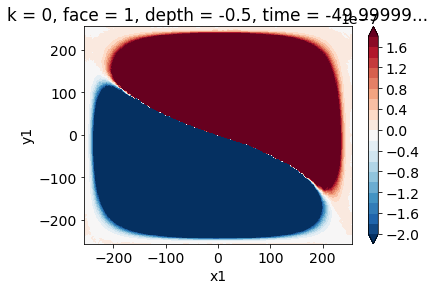

In [27]:
(omega_x_tor*dsigdx_tor+omega_y_tor*dsigdy_tor+(f+zeta_tor)*dsigdz_tor
).real.plot(levels=np.arange(-1,1,0.1)*2*10**-7)#levels=np.arange(-1,1,0.1)*2*10**-7

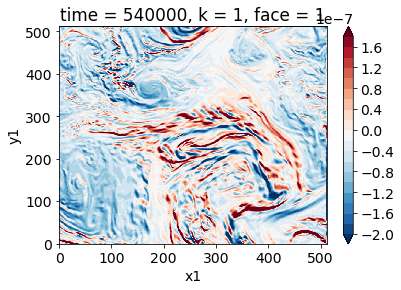

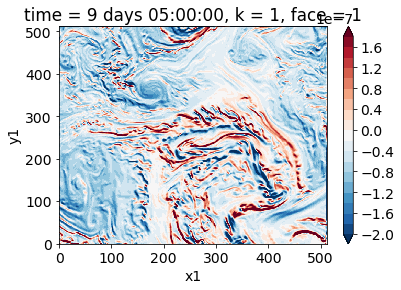

In [129]:
#

Text(0.5, 1.0, '')

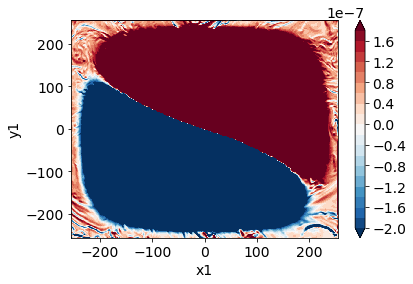

In [130]:
(omega_x_tor*dsigdx_tor+omega_y_tor*dsigdy_tor+(f+zeta_tor)*dsigdz_tor
-omega_x*dsigdx-omega_y*dsigdy-(f+zeta)*dsigdz).real.plot(levels=np.arange(-1,1,0.1)*2*10**-7)
plt.title('')

Text(0.5, 1.0, '')

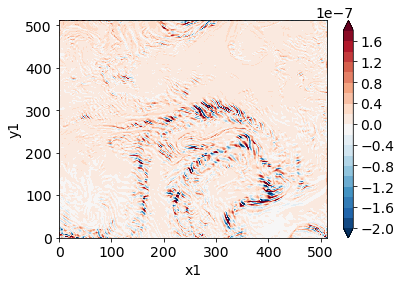

In [131]:
(omega_x_eulf*dsigdx_eulf+omega_y_eulf*dsigdy_eulf+(f+zeta_eulf)*dsigdz_eulf
-omega_x*dsigdx-omega_y*dsigdy-(f+zeta)*dsigdz).real.plot(levels=np.arange(-1,1,0.1)*2*10**-7)
plt.title('')

Text(0.5, 1.0, '')

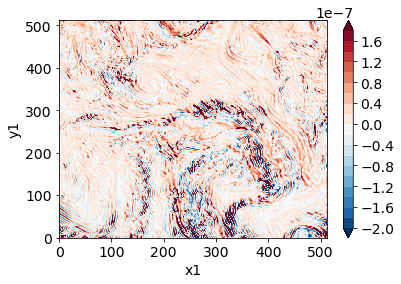

In [132]:
#PV made from Lagrangian filtered fields
(omega_x_lag*dsigdx_lag+omega_y_lag*dsigdy_lag+(f+zeta_lag)*dsigdz_lag
-omega_x*dsigdx-omega_y*dsigdy-(f+zeta)*dsigdz).real.plot(levels=np.arange(-1,1,0.1)*2*10**-7)
plt.title('')

Text(0.5, 1.0, '')

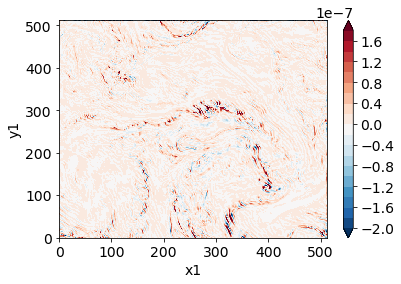

In [134]:
#dsigdz is the culprit!!
(omega_x_lag*dsigdx_lag+omega_y_lag*dsigdy_lag+(f+zeta_lag)*dsigdz
-omega_x*dsigdx-omega_y*dsigdy-(f+zeta)*dsigdz).real.plot(levels=np.arange(-1,1,0.1)*2*10**-7)
plt.title('')

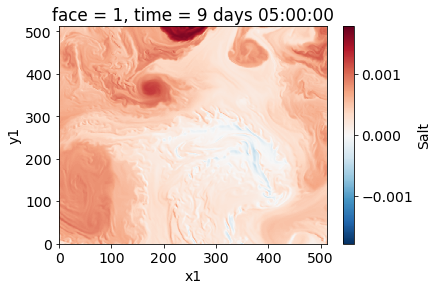

In [135]:
dsigdz.plot()

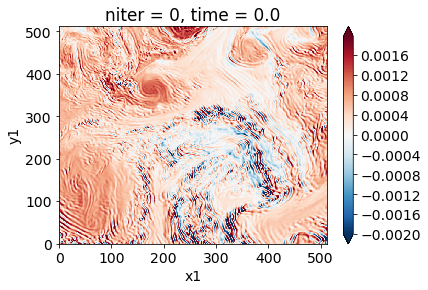

In [246]:
dsigdz_lag.plot(levels=np.arange(-1,1,0.01)*0.002)

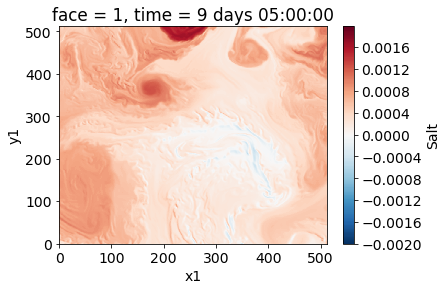

In [245]:
dsigdz.plot(levels=np.arange(-1,1,0.01)*0.002)

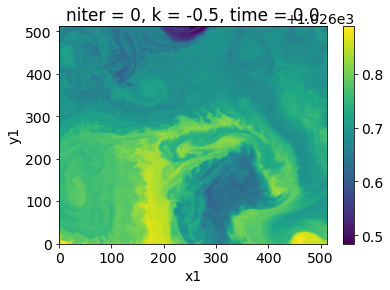

In [253]:
dens_resampled.isel(k=3).plot()

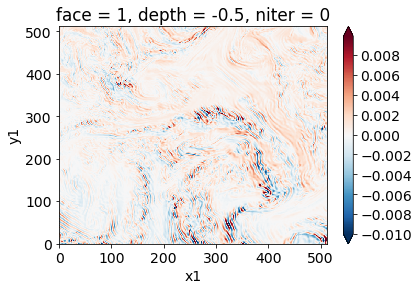

In [249]:
(dens_eul_resampled.sel(k=0)-dens_resampled.isel(k=3)).plot(levels=np.arange(-1,1,0.01)*0.01)

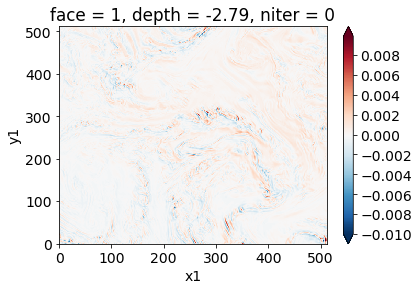

In [250]:
(dens_eul_resampled.sel(k=2)-dens_resampled.isel(k=1)).plot(levels=np.arange(-1,1,0.01)*0.01)

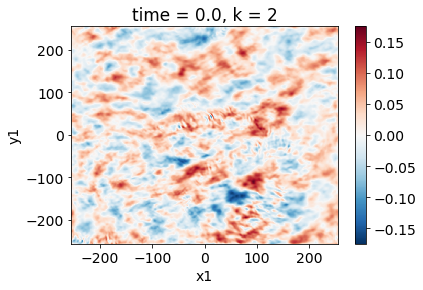

In [393]:
(v2_inv2.real-v_eul_resampled).isel(time=150,k=2).plot()

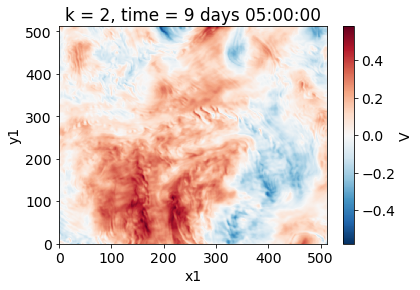

In [395]:
v_eul_resampled.isel(k=2).plot()

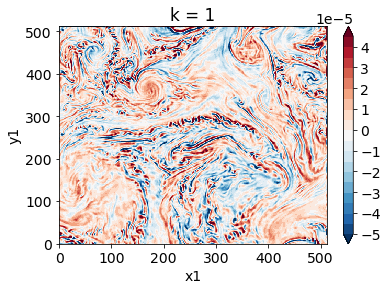

In [168]:
zeta.plot(levels=np.arange(-1,1,0.1)*5*10**-5)

In [165]:
test_v = np.fromfile('/swot/SUM03/spencer/swot_trimmed/vvel.0000021456.data',dtype='>f4')

In [166]:
test_v0 = test_v.reshape(-1,2160,2160)[0,:,:]
testv_ds = xr.DataArray(test_v0,dims=['y1_g','x1'])

In [167]:
testv_ds_int = grid1.interp(testv_ds,'Y')

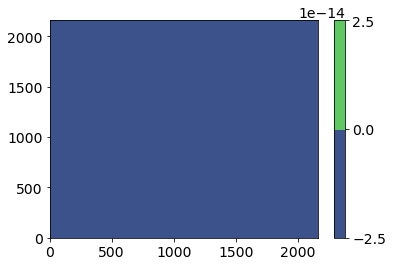

In [171]:
cs = plt.contourf(testv_ds_int.values-vvel_eul.V.isel(time=150,k=0).values)
plt.colorbar(cs)

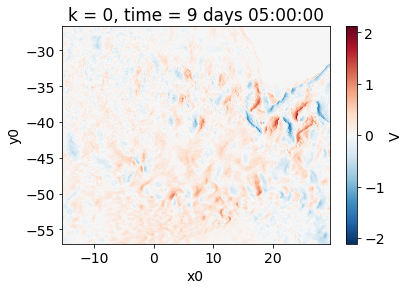

In [141]:
vvel_eul.V.isel(time=150,k=0).plot()

In [164]:
21600-144

21456

In [111]:
vvel_eul.V.time.isel(time=150)

<xarray.DataArray 'time' ()>
array(795600000000000, dtype='timedelta64[ns]')
Coordinates:
    time     timedelta64[ns] 9 days 05:00:00
Attributes:
    axis:           T
    calendar:       gregorian
    long_name:      Time
    standard_name:  time

In [113]:
795600000000000/10**9/25

31824.0